# GeoPandas Tutorial

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from shapely.geometry import Point, Polygon


import init
import whaletracks.common. constants as cn
from common_python.database import database_util as util
import obspy

## Constants

In [2]:
GEOMETRY = "geometry"
LON = "LON"
LAT = "LAT"

## USA Data

In [3]:
# Get county level data
path = os.path.join(cn.PROJECT_DIR, "examples/USAData/USA_adm2.shp")
if not (os.path.isfile(path)):
    print("Invalid path: %s" % path)
gdf_county = gpd.read_file(path)
gdf_county

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,244,USA,United States,1,Alabama,1,Autauga,County,County,None,None,"POLYGON ((-86.81896 32.34027, -86.81084 32.347..."
1,244,USA,United States,1,Alabama,2,Baldwin,County,County,None,None,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ..."
2,244,USA,United States,1,Alabama,3,Barbour,County,County,None,None,"POLYGON ((-85.13026 31.76386, -85.13504 31.768..."
3,244,USA,United States,1,Alabama,4,Bibb,County,County,None,None,"POLYGON ((-87.42078 32.87446, -87.42028 32.971..."
4,244,USA,United States,1,Alabama,5,Blount,County,County,None,None,"POLYGON ((-86.95322 33.81542, -86.95449 33.845..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3143,244,USA,United States,51,Wyoming,3144,Sweetwater,County,County,None,None,"POLYGON ((-110.00014 40.99923, -110.04850 40.9..."
3144,244,USA,United States,51,Wyoming,3145,Teton,County,County,None,None,"POLYGON ((-111.04494 43.50049, -111.04498 43.5..."
3145,244,USA,United States,51,Wyoming,3146,Uinta,County,County,None,None,"POLYGON ((-110.04850 40.99883, -110.05729 40.9..."
3146,244,USA,United States,51,Wyoming,3147,Washakie,County,County,None,None,"POLYGON ((-107.10772 43.49963, -107.14559 43.4..."


(25, 50)

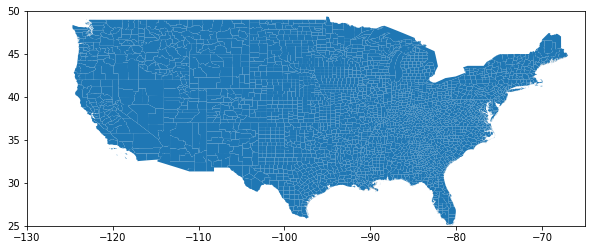

In [4]:
gdf_county.plot(figsize=(10, 12))
plt.xlim([-130, -65])
plt.ylim([25,50])

## IRIS Stations

In [5]:
if False:
    path = os.path.join(cn.DATA_DIR, "ALL-StationList.csv")
    gdf_sta = pd.read_csv(path)
    gdf_sta = gdf_sta[gdf_sta[LON] < 0]  # Eliminate outlier
    gdf_sta["geometry"] = gpd.GeoSeries([Point(float(x),float(y)) for x, y in zip(gdf_sta[LAT], gdf_sta[LON])])
    gdf_sta.head()

FileNotFoundError: [Errno 2] File b'/home/ubuntu/whaletracks/data/ALL-StationList.csv' does not exist: b'/home/ubuntu/whaletracks/data/ALL-StationList.csv'

In [ ]:
def checkRow(r):
    b = (r[LAT] <= 38) and (r[LAT] >= 34) and (r[LON] < -85) and (r[LON] > -93)
    #return b and ("WA" in r["SITE DESCRIPTION"])
    return b

results = [checkRow(r) for _, r in gdf_sta.iterrows()]
gdf_sta_wa = gdf_sta[results]
gdf_sta_wa["SITE DESCRIPTION"].unique()

In [ ]:
gdf_sta["point"] = gpd.GeoSeries([Point(float(x),float(y)) for x, y in zip(gdf_sta['LAT'], gdf_sta['LON'])])

In [ ]:
plt.scatter(gdf_sta[LON], gdf_sta[LAT])

## Combine Points With Map

In [ ]:
gdf_ca = gdf_county[gdf_county["NAME_1"] == "California"]

In [ ]:
gdf = gpd.GeoDataFrame(pd.concat([gdf_county, gdf_ca[GEOMETRY]]))
gdf = gpd.GeoDataFrame(pd.concat([gdf_ca[GEOMETRY]]))
gdf.columns = [GEOMETRY]
gdf.plot()
#plt.ylim([-120, -100])
#plt.xlim([40, 50])

In [ ]:
gdf_ca

## Select Stations Near the Continental US West Coast

In [ ]:
gdf_west = gdf_county[gdf_county["NAME_1"].isin(["California", "Oregon", "Washington"])]
len(gdf_west)

In [ ]:
def circleDistance(point1, point2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    :param Point point1:
    :param Point point2:
    :return float: distance in miles
    """
    lon1 = point1.y
    lat1 = point1.x
    lon2 = point2.y
    lat2 = point2.x
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

def getCount(idx):
    ser = gdf_west.iloc[idx]
    return ser[GEOMETRY]
poly1 = getCount(1)
poly3 = getCount(3)
circleDistance(poly1.centroid, poly3.centroid)

In [ ]:
poly1.centroid.y, poly1.centroid.x

In [ ]:
poly3.centroid.y, poly3.centroid.x

In [ ]:
len(gdf_sta)

## Creating SQL repositories

In [ ]:
df_station = util.csvToTable(cn.STATION_FILE, cn.DB_FILE, "stations")
df_blue_detection = util.csvToTable(cn.BLUE_DETECTION_FILE, cn.DB_FILE, "blue_detections")

In [ ]:
df_station.head()

In [ ]:
df_blue_detection.head()

## ObsPy

In [ ]:
def getStations(network_code, startime= UTCDateTime("2001-01-01"), 
                endtime=UTCDateTime("2020-01-02")):
    """
    Provides a dataframe of station metadata.
    :param str network_code:
    :return pd.DataFrame:
        station_code, channel_count, start_time, end_time, access, latitude, longitude, elevation
    """
    KEYS = [
     'code',
     'creation_date',
     'elevation',
     'end_date',
     'latitude',
     'longitude',
     'start_date',
     'termination_date',
     'total_number_of_channels'
    ]
    client = Client("IRIS")
    inventory = client.get_stations(network=network_code, station="*",
        starttime=starttime, endtime=endtime)
    network = inventory[0]
    station_count = network.total_number_of_stations
    station_dct = {k: [] for k in KEYS}
    station_dct["network"] = list(np.repeat(network_code, station_count))
    for idx in range(station_count):
        station = network[idx]
        for key in KEYS:
            station_dct[key].append(station.__getattribute__(key))
    if False:
        station_lines = network.get_contents()["stations"]
        station_codes = []
        for line in station_lines:
            splits = line.split(" ")
            station_codes.append(splits[0][-4:])
        return station_codes
    return pd.DataFrame(station_dct)



station_df = getStations("7D")

In [ ]:
station_df.head()

In [ ]:
station.__getattribute__("code")

In [ ]:

starttime = UTCDateTime("2001-01-01")

endtime = UTCDateTime("2020-01-02")
client = Client("IRIS")

inventory = client.get_stations(network="7D", station="*",

                                starttime=starttime,

                                endtime=endtime)
client = Client("IRIS")
#print(inventory)

if False:
    client = Client("IRIS")

    t1 = UTCDateTime("2010-02-27T06:30:00.000")

    t2 = t1 + 1

    t3 = t1 + 3

    bulk = [("IU", "ANMO", "*", "BHZ", t1, t2),

            ("IU", "AFI", "1?", "BHE", t1, t3),

            ("GR", "GRA1", "*", "BH*", t2, t3)]

    inv = client.get_stations_bulk(bulk, level="channel")
    print(inv)  

In [ ]:
inventory.get_contents()

In [ ]:
net = inventory[0]
net.total_number_of_stations

In [ ]:
net.stations

In [ ]:
station = net[0]; station

In [ ]:
str(station.creation_date)

In [ ]:
station.latitude, station.longitude

## Acquiring Channel Data